<a href="https://colab.research.google.com/github/Surya2004-janardhan/colab/blob/main/Image_Caption_Generator(Pytorch).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch==2.2
!pip install torchvision==0.17
!pip install nltk==3.7
!pip install pycocotools==2.0.7
!pip install numpy==1.23.5

import torch
import torchvision
import nltk
import pycocotools

print(torch.__version__)
print(torchvision.__version__)
print(nltk.__version__)

2.2.0+cu121
0.17.0+cu121
3.7


## Getting the data

In [2]:
# linux
!apt-get install wget
# mac
# !brew install wget

# create a data directory
!mkdir data_dir

# download images and annotations to the data directory
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip -P ./data_dir/
!wget http://images.cocodataset.org/zips/train2014.zip -P ./data_dir/
!wget http://images.cocodataset.org/zips/val2014.zip -P ./data_dir/

# extract zipped images and annotations and remove the zip files
!unzip ./data_dir/annotations_trainval2014.zip -d ./data_dir/
!rm ./data_dir/annotations_trainval2014.zip
!unzip ./data_dir/train2014.zip -d ./data_dir/
!rm ./data_dir/train2014.zip
!unzip ./data_dir/val2014.zip -d ./data_dir/
!rm ./data_dir/val2014.zip

Streaming output truncated to the last 5000 lines.
 extracting: ./data_dir/val2014/COCO_val2014_000000535608.jpg  
 extracting: ./data_dir/val2014/COCO_val2014_000000279145.jpg  
 extracting: ./data_dir/val2014/COCO_val2014_000000243495.jpg  
 extracting: ./data_dir/val2014/COCO_val2014_000000225791.jpg  
 extracting: ./data_dir/val2014/COCO_val2014_000000428067.jpg  
 extracting: ./data_dir/val2014/COCO_val2014_000000059383.jpg  
 extracting: ./data_dir/val2014/COCO_val2014_000000558498.jpg  
 extracting: ./data_dir/val2014/COCO_val2014_000000376123.jpg  
 extracting: ./data_dir/val2014/COCO_val2014_000000191304.jpg  
 extracting: ./data_dir/val2014/COCO_val2014_000000171062.jpg  
 extracting: ./data_dir/val2014/COCO_val2014_000000014549.jpg  
 extracting: ./data_dir/val2014/COCO_val2014_000000121152.jpg  
 extracting: ./data_dir/val2014/COCO_val2014_000000276596.jpg  
 extracting: ./data_dir/val2014/COCO_val2014_000000029431.jpg  
 extracting: ./data_dir/val2014/COCO_val2014_00000003

## Importing the modules

In [6]:
import os
import nltk
import pickle
import numpy as np
from PIL import Image
from collections import Counter
from pycocotools.coco import COCO
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.utils.data as data
from torchvision import transforms
import torchvision.models as models
import torchvision.transforms as transforms
from torch.nn.utils.rnn import pack_padded_sequence

In [7]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Making the vocab class

In [8]:
class Vocab(object):
    """Simple vocabulary wrapper."""
    def __init__(self):
        self.w2i = {}
        self.i2w = {}
        self.index = 0

    def __call__(self, token):
        if not token in self.w2i:
            return self.w2i['<unk>']
        return self.w2i[token]

    def __len__(self):
        return len(self.w2i)
    def add_token(self, token):
        if not token in self.w2i:
            self.w2i[token] = self.index
            self.i2w[self.index] = token
            self.index += 1

def build_vocabulary(json, threshold):
    """Build a simple vocabulary wrapper."""
    coco = COCO(json)
    counter = Counter()
    ids = coco.anns.keys()
    for i, id in enumerate(ids):
        caption = str(coco.anns[id]['caption'])
        tokens = nltk.tokenize.word_tokenize(caption.lower())
        counter.update(tokens)

        if (i+1) % 1000 == 0:
            print("[{}/{}] Tokenized the captions.".format(i+1, len(ids)))

    # If the word frequency is less than 'threshold', then the word is discarded.
    tokens = [token for token, cnt in counter.items() if cnt >= threshold]

    # Create a vocab wrapper and add some special tokens.
    vocab = Vocab()
    vocab.add_token('<pad>')
    vocab.add_token('<start>')
    vocab.add_token('<end>')
    vocab.add_token('<unk>')

    # Add the words to the vocabulary.
    for i, token in enumerate(tokens):
        vocab.add_token(token)
    return vocab

vocab = build_vocabulary(json='data_dir/annotations/captions_train2014.json', threshold=4)
vocab_path = './data_dir/vocabulary.pkl'
with open(vocab_path, 'wb') as f:
    pickle.dump(vocab, f)
print("Total vocabulary size: {}".format(len(vocab)))
print("Saved the vocabulary wrapper to '{}'".format(vocab_path))

loading annotations into memory...
Done (t=1.14s)
creating index...
index created!
[1000/414113] Tokenized the captions.
[2000/414113] Tokenized the captions.
[3000/414113] Tokenized the captions.
[4000/414113] Tokenized the captions.
[5000/414113] Tokenized the captions.
[6000/414113] Tokenized the captions.
[7000/414113] Tokenized the captions.
[8000/414113] Tokenized the captions.
[9000/414113] Tokenized the captions.
[10000/414113] Tokenized the captions.
[11000/414113] Tokenized the captions.
[12000/414113] Tokenized the captions.
[13000/414113] Tokenized the captions.
[14000/414113] Tokenized the captions.
[15000/414113] Tokenized the captions.
[16000/414113] Tokenized the captions.
[17000/414113] Tokenized the captions.
[18000/414113] Tokenized the captions.
[19000/414113] Tokenized the captions.
[20000/414113] Tokenized the captions.
[21000/414113] Tokenized the captions.
[22000/414113] Tokenized the captions.
[23000/414113] Tokenized the captions.
[24000/414113] Tokenized the 

## Shaping up the images

In [9]:
def reshape_image(image, shape):
    """Resize an image to the given shape."""
    return image.resize(shape, Image.LANCZOS)

def reshape_images(image_path, output_path, shape):
    """Reshape the images in 'image_path' and save into 'output_path'."""
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    images = os.listdir(image_path)
    num_im = len(images)
    for i, im in enumerate(images):
        with open(os.path.join(image_path, im), 'r+b') as f:
            with Image.open(f) as image:
                image = reshape_image(image, shape)
                image.save(os.path.join(output_path, im), image.format)
        if (i+1) % 100 == 0:
            print ("[{}/{}] Resized the images and saved into '{}'."
                   .format(i+1, num_im, output_path))

image_path = './data_dir/train2014/'
output_path = './data_dir/resized_images/'
image_shape = [256, 256]
reshape_images(image_path, output_path, image_shape)

[100/82783] Resized the images and saved into './data_dir/resized_images/'.
[200/82783] Resized the images and saved into './data_dir/resized_images/'.
[300/82783] Resized the images and saved into './data_dir/resized_images/'.
[400/82783] Resized the images and saved into './data_dir/resized_images/'.
[500/82783] Resized the images and saved into './data_dir/resized_images/'.
[600/82783] Resized the images and saved into './data_dir/resized_images/'.
[700/82783] Resized the images and saved into './data_dir/resized_images/'.
[800/82783] Resized the images and saved into './data_dir/resized_images/'.
[900/82783] Resized the images and saved into './data_dir/resized_images/'.
[1000/82783] Resized the images and saved into './data_dir/resized_images/'.
[1100/82783] Resized the images and saved into './data_dir/resized_images/'.
[1200/82783] Resized the images and saved into './data_dir/resized_images/'.
[1300/82783] Resized the images and saved into './data_dir/resized_images/'.
[1400/82

## Setting up the dataset

In [11]:
class CustomCocoDataset(data.Dataset):
    """COCO Custom Dataset compatible with torch.utils.data.DataLoader."""
    def __init__(self, data_path, coco_json_path, vocabulary, transform=None):
        """Set the path for images, captions and vocabulary wrapper.

        Args:
            root: image directory.
            json: coco annotation file path.
            vocab: vocabulary wrapper.
            transform: image transformer.
        """
        self.root = data_path
        self.coco_data = COCO(coco_json_path)
        self.indices = list(self.coco_data.anns.keys())
        self.vocabulary = vocabulary
        self.transform = transform

    def __getitem__(self, idx):
        """Returns one data pair (image and caption)."""
        coco_data = self.coco_data
        vocabulary = self.vocabulary
        annotation_id = self.indices[idx]
        caption = coco_data.anns[annotation_id]['caption']
        image_id = coco_data.anns[annotation_id]['image_id']
        image_path = coco_data.loadImgs(image_id)[0]['file_name']

        image = Image.open(os.path.join(self.root, image_path)).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)

        # Convert caption (string) to word ids.
        word_tokens = nltk.tokenize.word_tokenize(str(caption).lower())
        caption = []
        caption.append(vocabulary('<start>'))
        caption.extend([vocabulary(token) for token in word_tokens])
        caption.append(vocabulary('<end>'))
        ground_truth = torch.Tensor(caption)
        return image, ground_truth

    def __len__(self):
        return len(self.indices)


def collate_function(data_batch):
    """Creates mini-batch tensors from the list of tuples (image, caption).

    We should build custom collate_fn rather than using default collate_fn,
    because merging caption (including padding) is not supported in default.
    Args:
        data: list of tuple (image, caption).
            - image: torch tensor of shape (3, 256, 256).
            - caption: torch tensor of shape (?); variable length.
    Returns:
        images: torch tensor of shape (batch_size, 3, 256, 256).
        targets: torch tensor of shape (batch_size, padded_length).
        lengths: list; valid length for each padded caption.
    """
    # Sort a data list by caption length (descending order).
    data_batch.sort(key=lambda d: len(d[1]), reverse=True)
    imgs, caps = zip(*data_batch)

    # Merge images (from list of 3D tensors to 4D tensor).
    # Originally, imgs is a list of <batch_size> number of RGB images with dimensions (3, 256, 256)
    # This line of code turns it into a single tensor of dimensions (<batch_size>, 3, 256, 256)
    imgs = torch.stack(imgs, 0)

    # Merge captions (from list of 1D tensors to 2D tensor), similar to merging of images donw above.
    cap_lens = [len(cap) for cap in caps]
    tgts = torch.zeros(len(caps), max(cap_lens)).long()
    for i, cap in enumerate(caps):
        end = cap_lens[i]
        tgts[i, :end] = cap[:end]
    return imgs, tgts, cap_lens

def get_loader(data_path, coco_json_path, vocabulary, transform, batch_size, shuffle):
    """Returns torch.utils.data.DataLoader for custom coco dataset."""
    # COCO caption dataset
    coco_dataser = CustomCocoDataset(data_path=data_path,
                       coco_json_path=coco_json_path,
                       vocabulary=vocabulary,
                       transform=transform)

    # Data loader for COCO dataset
    # This will return (images, captions, lengths) for each iteration.
    # images: a tensor of shape (batch_size, 3, 224, 224).
    # captions: a tensor of shape (batch_size, padded_length).
    # lengths: a list indicating valid length for each caption. length is (batch_size).
    custom_data_loader = torch.utils.data.DataLoader(dataset=coco_dataser,
                                              batch_size=batch_size,
                                              shuffle=shuffle,
                                              collate_fn=collate_function)
    return custom_data_loader

In [12]:
import os

## Framing the model

In [13]:
class CNNModel(nn.Module):
    def __init__(self, embedding_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(CNNModel, self).__init__()
        resnet = models.resnet152(weights=True)
        module_list = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet_module = nn.Sequential(*module_list)
        self.linear_layer = nn.Linear(resnet.fc.in_features, embedding_size)
        self.batch_norm = nn.BatchNorm1d(embedding_size, momentum=0.01)

    def forward(self, input_images):
        """Extract feature vectors from input images."""
        with torch.no_grad():
            resnet_features = self.resnet_module(input_images)
        resnet_features = resnet_features.reshape(resnet_features.size(0), -1)
        final_features = self.batch_norm(self.linear_layer(resnet_features))
        return final_features


class LSTMModel(nn.Module):
    def __init__(self, embedding_size, hidden_layer_size, vocabulary_size, num_layers, max_seq_len=20):
        """Set the hyper-parameters and build the layers."""
        super(LSTMModel, self).__init__()
        self.embedding_layer = nn.Embedding(vocabulary_size, embedding_size)
        self.lstm_layer = nn.LSTM(embedding_size, hidden_layer_size, num_layers, batch_first=True)
        self.linear_layer = nn.Linear(hidden_layer_size, vocabulary_size)
        self.max_seq_len = max_seq_len

    def forward(self, input_features, capts, lens):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embedding_layer(caps)
        embeddings = torch.cat((input_features.unsqueeze(1), embeddings), 1)
        lstm_input = pack_padded_sequence(embeddings, lens, batch_first=True)
        hidden_variables, _ = self.lstm_layer(lstm_input)
        model_outputs = self.linear_layer(hidden_variables[0])
        return model_outputs

    def sample(self, input_features, lstm_states=None):
        """Generate captions for given image features using greedy search."""
        sampled_indices = []
        lstm_inputs = input_features.unsqueeze(1)
        for i in range(self.max_seq_len):
            hidden_variables, lstm_states = self.lstm_layer(lstm_inputs, lstm_states)          # hiddens: (batch_size, 1, hidden_size)
            model_outputs = self.linear_layer(hidden_variables.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted_outputs = model_outputs.max(1)                        # predicted: (batch_size)
            sampled_indices.append(predicted_outputs)
            lstm_inputs = self.embedding_layer(predicted_outputs)                       # inputs: (batch_size, embed_size)
            lstm_inputs = lstm_inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_indices = torch.stack(sampled_indices, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_indices

## Getting the trained looped data

In [14]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Create model directory
if not os.path.exists('models_dir/'):
    os.makedirs('models_dir/')


# Image preprocessing, normalization for the pretrained resnet
transform = transforms.Compose([
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))])


# Load vocabulary wrapper
with open('data_dir/vocabulary.pkl', 'rb') as f:
    vocabulary = pickle.load(f)


# Build data loader
custom_data_loader = get_loader('data_dir/resized_images', 'data_dir/annotations/captions_train2014.json', vocabulary,
                         transform, 128,
                         shuffle=True)

# Build the models
encoder_model = CNNModel(256).to(device)
decoder_model = LSTMModel(256, 512, len(vocabulary), 1).to(device)


# Loss and optimizer
loss_criterion = nn.CrossEntropyLoss()
parameters = list(decoder_model.parameters()) + list(encoder_model.linear_layer.parameters()) + list(encoder_model.batch_norm.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.001)


# Train the models
total_num_steps = len(custom_data_loader)
for epoch in range(2):
    print("epoch-started",epoch)
    for i, (imgs, caps, lens) in enumerate(custom_data_loader):

        # Set mini-batch dataset
        imgs = imgs.to(device)
        caps = caps.to(device)
        tgts = pack_padded_sequence(caps, lens, batch_first=True)[0]

        # Forward, backward and optimize
        feats = encoder_model(imgs)
        outputs = decoder_model(feats, caps, lens)
        loss = loss_criterion(outputs, tgts)
        decoder_model.zero_grad()
        encoder_model.zero_grad()
        loss.backward()
        optimizer.step()

        # Print log info
        if i % 10 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}'
                  .format(epoch, 5, i, total_num_steps, loss.item(), np.exp(loss.item())))

        # Save the model checkpoints
        if (i+1) % 1000 == 0:
            torch.save(decoder_model.state_dict(), os.path.join(
                'models_dir/', 'decoder-{}-{}.ckpt'.format(epoch+1, i+1)))
            torch.save(encoder_model.state_dict(), os.path.join(
                'models_dir/', 'encoder-{}-{}.ckpt'.format(epoch+1, i+1)))
    print("epoch-ended",epoch)


loading annotations into memory...
Done (t=1.10s)
creating index...
index created!


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 125MB/s]


epoch-started 0
Epoch [0/5], Step [0/3236], Loss: 9.2027, Perplexity: 9924.0449
Epoch [0/5], Step [10/3236], Loss: 5.8419, Perplexity: 344.4223
Epoch [0/5], Step [20/3236], Loss: 5.3315, Perplexity: 206.7497
Epoch [0/5], Step [30/3236], Loss: 4.8341, Perplexity: 125.7286
Epoch [0/5], Step [40/3236], Loss: 4.4864, Perplexity: 88.8018
Epoch [0/5], Step [50/3236], Loss: 4.5780, Perplexity: 97.3207
Epoch [0/5], Step [60/3236], Loss: 4.2787, Perplexity: 72.1500
Epoch [0/5], Step [70/3236], Loss: 4.0653, Perplexity: 58.2844
Epoch [0/5], Step [80/3236], Loss: 4.0781, Perplexity: 59.0321
Epoch [0/5], Step [90/3236], Loss: 3.8784, Perplexity: 48.3486
Epoch [0/5], Step [100/3236], Loss: 3.8188, Perplexity: 45.5506
Epoch [0/5], Step [110/3236], Loss: 3.7291, Perplexity: 41.6433
Epoch [0/5], Step [120/3236], Loss: 3.6801, Perplexity: 39.6488
Epoch [0/5], Step [130/3236], Loss: 3.7041, Perplexity: 40.6120
Epoch [0/5], Step [140/3236], Loss: 3.6669, Perplexity: 39.1306
Epoch [0/5], Step [150/3236], 

<start> a woman with a hat on her head . <end>


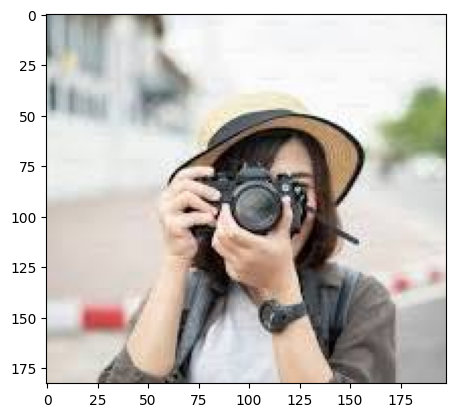

In [38]:
image_file_path = '/content/download.jpg'


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def load_image(image_file_path, transform=None):
    img = Image.open(image_file_path).convert('RGB')
    img = img.resize([224, 224], Image.LANCZOS)

    if transform is not None:
        img = transform(img).unsqueeze(0)

    return img


# Image preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))])


# Load vocabulary wrapper
with open('data_dir/vocabulary.pkl', 'rb') as f:
    vocabulary = pickle.load(f)


# Build models
encoder_model = CNNModel(256).eval()  # eval mode (batchnorm uses moving mean/variance)
decoder_model = LSTMModel(256, 512, len(vocabulary), 1)
encoder_model = encoder_model.to(device)
decoder_model = decoder_model.to(device)


# Load the trained model parameters
encoder_model.load_state_dict(torch.load('models_dir/encoder-2-3000.ckpt'))
decoder_model.load_state_dict(torch.load('models_dir/decoder-2-3000.ckpt'))


# Prepare an image
img = load_image(image_file_path, transform)
img_tensor = img.to(device)


# Generate an caption from the image
feat = encoder_model(img_tensor)
sampled_indices = decoder_model.sample(feat)
sampled_indices = sampled_indices[0].cpu().numpy()          # (1, max_seq_length) -> (max_seq_length)


# Convert word_ids to words
predicted_caption = []
for token_index in sampled_indices:
    word = vocabulary.i2w[token_index]
    predicted_caption.append(word)
    if word == '<end>':
        break
predicted_sentence = ' '.join(predicted_caption)


# Print out the image and the generated caption
print (predicted_sentence)
img = Image.open(image_file_path)
plt.imshow(np.asarray(img))

In [16]:
# After training, save the final trained model
torch.save(encoder_model.state_dict(), 'models_dir/encoder_final.pth')
torch.save(decoder_model.state_dict(), 'models_dir/decoder_final.pth')

# Save optimizer state (useful for resuming training)
torch.save(optimizer.state_dict(), 'models_dir/optimizer.pth')

# Save model architecture + weights
torch.save(encoder_model, 'models_dir/encoder_full.pth')
torch.save(decoder_model, 'models_dir/decoder_full.pth')

print("Final models and optimizer saved successfully!")


Final models and optimizer saved successfully!


In [17]:
# Load the model's weights into a new instance
encoder_model = CNNModel(256).to(device)
encoder_model.load_state_dict(torch.load('models_dir/encoder_final.pth'))

decoder_model = LSTMModel(256, 512, len(vocabulary), 1).to(device)
decoder_model.load_state_dict(torch.load('models_dir/decoder_final.pth'))

encoder_model.eval()  # Set to evaluation mode
decoder_model.eval()
print("Models loaded successfully!")


Models loaded successfully!


In [18]:
encoder_model = torch.load('models_dir/encoder_full.pth')
decoder_model = torch.load('models_dir/decoder_full.pth')
encoder_model.eval()
decoder_model.eval()
print("Full models loaded successfully!")


Full models loaded successfully!


In [19]:
optimizer.load_state_dict(torch.load('models_dir/optimizer.pth'))


In [20]:
import torch
import pickle

# Define the model checkpoint path
model_path = "models_dir/final_model.pkl"

# Save the entire model (both encoder and decoder)
torch.save({
    'encoder_state_dict': encoder_model.state_dict(),
    'decoder_state_dict': decoder_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}, model_path)

print(f"Model saved as {model_path}")


Model saved as models_dir/final_model.pkl


In [21]:
# Load the saved model
checkpoint = torch.load("models_dir/final_model.pkl")

# Restore model weights
encoder_model.load_state_dict(checkpoint['encoder_state_dict'])
decoder_model.load_state_dict(checkpoint['decoder_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

print("Model successfully loaded!")


Model successfully loaded!


In [22]:
import torch
import pickle
from torchvision import transforms
from PIL import Image

# Load vocabulary
with open('data_dir/vocabulary.pkl', 'rb') as f:
    vocabulary = pickle.load(f)

# Load the saved model
checkpoint = torch.load("models_dir/final_model.pkl", map_location=torch.device('cpu'))

# Load encoder and decoder model states
encoder_model.load_state_dict(checkpoint['encoder_state_dict'])
decoder_model.load_state_dict(checkpoint['decoder_state_dict'])

# Set models to evaluation mode
encoder_model.eval()
decoder_model.eval()

print("Model successfully loaded and ready for testing!")


Model successfully loaded and ready for testing!


In [25]:
# Define the same preprocessing used during training
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Load and preprocess the image
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image.to(device)

# Example usage
image_path = "/content/download.jpg"  # Change to your test image path
input_image = preprocess_image(image_path)


In [28]:
def generate_caption(image_tensor, encoder, decoder, vocabulary, max_length=20):
    with torch.no_grad():
        # Extract image features
        features = encoder(image_tensor)

        # Initialize LSTM hidden state
        sampled_ids = []
        inputs = torch.tensor([vocabulary.w2i['<start>']]).unsqueeze(0).to(device)

        for _ in range(max_length):
            outputs = decoder(features, inputs, [1])  # Generate next word
            predicted = outputs.argmax(1)  # Get index of highest probability word
            sampled_ids.append(predicted.item())
            inputs = predicted.unsqueeze(0)  # Next input

            if vocabulary.idx2word[predicted.item()] == '<end>':
                break

        # Convert word indexes to words
        caption = ' '.join([vocabulary.idx2word[word_id] for word_id in sampled_ids if word_id in vocabulary.idx2word])
        return caption

# Generate caption for the test image
caption = generate_caption(input_image, encoder_model, decoder_model, vocabulary)
print("Generated Caption:", caption)


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 1 but got size 33 for tensor number 1 in the list.

In [29]:
print("input_features shape:", input_features.shape)
print("embeddings shape:", embeddings.shape)


NameError: name 'input_features' is not defined

In [33]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import pickle

# Load the saved models
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load vocabulary
with open('data_dir/vocabulary.pkl', 'rb') as f:
    vocabulary = pickle.load(f)

# Load trained models
encoder_model = CNNModel(256).to(device)
decoder_model = LSTMModel(256, 512, len(vocabulary), 1).to(device)
encoder_model.load_state_dict(torch.load('models_dir/encoder-2-3000.ckpt'))
decoder_model.load_state_dict(torch.load('models_dir/decoder-2-3000.ckpt'))
# encoder_model.load_state_dict(torch.load('/content/models_dir/decoder_final.pth', map_location=device))
# decoder_model.load_state_dict(torch.load('/content/models_dir/encoder_final.pth', map_location=device))

encoder_model.eval()
decoder_model.eval()

# Define image preprocessing (same as training)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Function to preprocess and test on an image
def generate_caption(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    # Extract features using encoder
    features = encoder_model(image)

    # Generate caption using decoder
    sampled_ids = []
    inputs = torch.tensor([vocabulary.w2i['<start>']]).unsqueeze(0).to(device)

    with torch.no_grad():
        for _ in range(20):  # Max caption length
            hidden_state, _ = decoder_model.lstm_layer(decoder_model.embedding_layer(inputs))
            outputs = decoder_model.linear_layer(hidden_state.squeeze(1))
            predicted = outputs.argmax(1)
            sampled_ids.append(predicted.item())

            if predicted.item() == vocabulary.w2i['<end>']:
                break

            inputs = predicted.unsqueeze(0)

    # Convert word indices to words
    caption = [vocabulary.i2w[idx] for idx in sampled_ids]
    caption = ' '.join(caption).replace('<end>', '')

    return caption

# Test with an uploaded image
image_path = "/content/download.jpg"  # Change this to your actual test image path
caption = generate_caption(image_path)
print("Generated Caption:", caption)


Generated Caption: a <start> a <start> a <start> a <start> a <start> a <start> a <start> a <start> a <start> a <start>


In [35]:
# Save the final trained models as .ckpt files
torch.save(decoder_model.state_dict(), 'models_dir/final_decoder.ckpt')
torch.save(encoder_model.state_dict(), 'models_dir/final_encoder.ckpt')

print("Final models saved successfully as .ckpt!")


Final models saved successfully as .ckpt!


In [37]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import pickle

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load vocabulary
with open('data_dir/vocabulary.pkl', 'rb') as f:
    vocabulary = pickle.load(f)

# Initialize model structure
encoder_model = CNNModel(256).to(device)
decoder_model = LSTMModel(256, 512, len(vocabulary), 1).to(device)

# Load trained models from .ckpt files
encoder_model.load_state_dict(torch.load('/content/models_dir/encoder-2-3000.ckpt', map_location=device))
decoder_model.load_state_dict(torch.load('/content/models_dir/decoder-2-3000.ckpt', map_location=device))

encoder_model.eval()
decoder_model.eval()

# Image preprocessing (same as training)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Function to generate a caption
def generate_caption(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    # Extract features using encoder
    features = encoder_model(image)

    # Generate caption using decoder
    sampled_ids = []
    inputs = torch.tensor([vocabulary.w2i['<start>']]).unsqueeze(0).to(device)

    with torch.no_grad():
        for _ in range(20):  # Max caption length
            hidden_state, _ = decoder_model.lstm_layer(decoder_model.embedding_layer(inputs))
            outputs = decoder_model.linear_layer(hidden_state.squeeze(1))
            predicted = outputs.argmax(1)
            sampled_ids.append(predicted.item())

            if predicted.item() == vocabulary.w2i['<end>']:
                break

            inputs = predicted.unsqueeze(0)

    # Convert word indices to words
    caption = [vocabulary.i2w[idx] for idx in sampled_ids]
    caption = ' '.join(caption).replace('<end>', '')

    return caption

# Test with an uploaded image
image_path = "/content/download.jpg"  # Change this to your actual test image path
caption = generate_caption(image_path)
print("Generated Caption:", caption)


Generated Caption: a <start> a <start> a <start> a <start> a <start> a <start> a <start> a <start> a <start> a <start>
